In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon
import fsps
from spec_id import Scale_model

import dynesty

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [4]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1)
wave, flux = sp.get_spectrum(tage = 2.0, peraa = True)

Gs = Gen_spec('GND', 21156, 1.2539,
               g102_lims=[7900, 11300], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = False)  

# Gs.Make_sim(0.019, 3.2, 0.2 , 1.2, 0)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [17]:
template_path = '../templates/'
    
tau_range = np.load(template_path + 'tau_range.npy')
metal_range = np.load(template_path + 'metal_range.npy')
age_range = np.load(template_path + 'age_range.npy')
lwagrid = np.load(template_path + 'lwa_grid.npy')

ilwagrid = RegularGridInterpolator([metal_range,tau_range],lwagrid)

In [6]:
# prior transform
specz = 1.2539
bft = 0.545
bfd = 0.2

if bft <= 0.5:
    tau_limit = 0.5
    
if 0.5 < bft <= 1.0:
    tau_limit = 1.0
    
if bft > 1.0:
    tau_limit = 2.0
    
if bfd <= 0.5:
    dust_limit = 0.5
    
if 0.5 < bfd <= 1.0:
    dust_limit = 1.0
    
if bfd > 1.0:
    dust_limit = 2.0

def prior_transform(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = 5. * u[1] + 0.1
    t = tau_limit*u[2] + 0.01
    z = specz + 0.003 * (2*u[3] - 1)
    d = dust_limit*u[4]
    
    lwvs = ilwagrid([m,t])[0]

    lwa = interp1d(age_range,lwvs)(a)
        
    return [m, lwa, t, z, d]

In [44]:
def Full_forward_model(spec, wave, flux, specz):
#     Bmfl = spec.Forward_model_all_beams(spec.Bbeam, spec.Bwv, wave * (1 + specz), flux)
#     Rmfl = spec.Forward_model_all_beams(spec.Rbeam, spec.Rwv, wave * (1 + specz), flux)
    
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)
    
#     return Bmfl, Rmfl, Pmfl
    return Pmfl

def Full_scale(spec, Bmfl, Rmfl, Pmfl):
#     BC = Scale_model(spec.Bflx, spec.Berr, Bmfl)
#     RC = Scale_model(spec.Rflx, spec.Rerr, Rmfl)
    PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    
#     return BC, RC, PC
    return PC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):
#     Bchi = np.sum((((spec.Bflx - Bmfl) / spec.Berr)**2))
#     Rchi = np.sum((((spec.Rflx - Rmfl) / spec.Rerr)**2))
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
#     return Bchi, Rchi, Pchi
    return Pchi

def loglikelihood(X):
    m,lwa,t,z,d = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['tau'] = t
    
    lwvs = ilwagrid([m,t])[0]

    a = interp1d(lwvs,age_range)(lwa)
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
        
#     Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux * Salmon(d, wave), z)
    
#     BC, RC, PC = Full_scale(Gs, Bmfl, Rmfl, Pmfl)

#     Bchi, Rchi, Pchi = Full_fit(Gs, BC * Bmfl, RC * Rmfl, PC * Pmfl)
                  
#     return -0.5 * (Bchi + Rchi + Pchi)

    Bmfl, Rmfl = Full_forward_model(Gs, wave, flux * Salmon(d, wave), z)
    BC, RC = Full_scale(Gs, Bmfl, Rmfl, 1)
    Bchi, Rchi = Full_fit(Gs, BC * Bmfl, RC * Rmfl, 1)
    return -0.5 * (Bchi + Rchi)

In [35]:
import ipyparallel as ipp

rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)

dview = rc[:]
dview.use_dill();

class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        self.size = nprocs
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)

[0, 1, 2, 3]


In [45]:
%%px

# import environment
import fsps
from spec_exam import Gen_spec
from sim_engine import *
import dynesty
from scipy.interpolate import interp1d, RegularGridInterpolator

specz = 1.2539
bft = 0.545
bfd = 0.2

template_path = '../templates/'
    
tau_range = np.load(template_path + 'tau_range.npy')
metal_range = np.load(template_path + 'metal_range.npy')
age_range = np.load(template_path + 'age_range.npy')
lwagrid = np.load(template_path + 'lwa_grid.npy')

ilwagrid = RegularGridInterpolator([metal_range,tau_range],lwagrid)

if bft <= 0.5:
    tau_limit = 0.5
    
if 0.5 < bft <= 1.0:
    tau_limit = 1.0
    
if bft > 1.0:
    tau_limit = 2.0
    
if bfd <= 0.5:
    dust_limit = 0.5
    
if 0.5 < bfd <= 1.0:
    dust_limit = 1.0
    
if bfd > 1.0:
    dust_limit = 2.0
    
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1)

Gs = Gen_spec('GND', 21156, 1.2529, g102_lims=[7900, 11300], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = False)  

def Full_forward_model(spec, wave, flux, specz):
    Bmfl = spec.Forward_model_all_beams(spec.Bbeam, spec.Bwv, wave * (1 + specz), flux)
    Rmfl = spec.Forward_model_all_beams(spec.Rbeam, spec.Rwv, wave * (1 + specz), flux)
    
#     Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)
    
#     return Bmfl, Rmfl, Pmfl
    return Bmfl, Rmfl

def Full_scale(spec, Bmfl, Rmfl, Pmfl):
    BC = Scale_model(spec.Bflx, spec.Berr, Bmfl)
    RC = Scale_model(spec.Rflx, spec.Rerr, Rmfl)
#     PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    
#     return BC, RC, PC
    return BC, RC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):
    Bchi = np.sum((((spec.Bflx - Bmfl) / spec.Berr)**2))
    Rchi = np.sum((((spec.Rflx - Rmfl) / spec.Rerr)**2))
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
#     return Bchi, Rchi, Pchi
    return Bchi, Rchi

# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:',os.getpid())

[stdout:0] Random seed: 51483
[stdout:1] Random seed: 51484
[stdout:2] Random seed: 51485
[stdout:3] Random seed: 51486


[stderr:0] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
[stderr:1] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data[

In [46]:
# initialize our nested sampler
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim = 5, sample = 'rwalk',pool=pool, bound = 'single') 

In [47]:
# sample dynamically from the target distribution
dsampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.001, print_progress=True)


iter: 19402 | batch: 8 | bound: 837 | nc: 25 | ncall: 447969 | eff(%):  4.331 | loglstar: -90.868 < -84.504 < -85.546 | logz: -91.867 +/-  0.095 | stop:  0.954            


In [48]:
# save results

# dres = dsampler.results
dresG = dsampler.results


In [39]:
'done'

'done'

In [23]:
from dynesty import plotting as dyplot

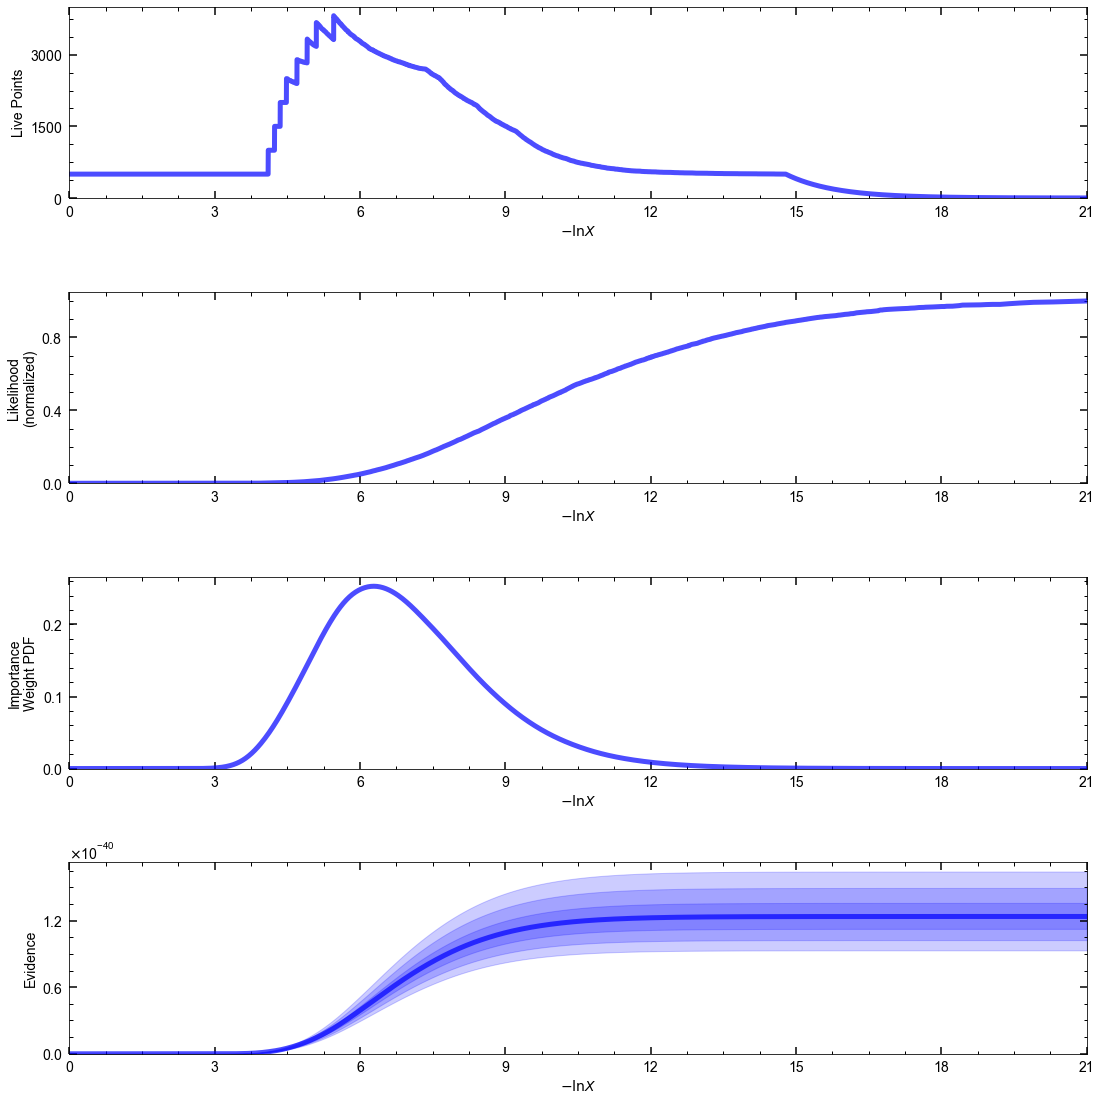

In [49]:
fig, axes = dyplot.runplot(dresG)

fig.tight_layout()

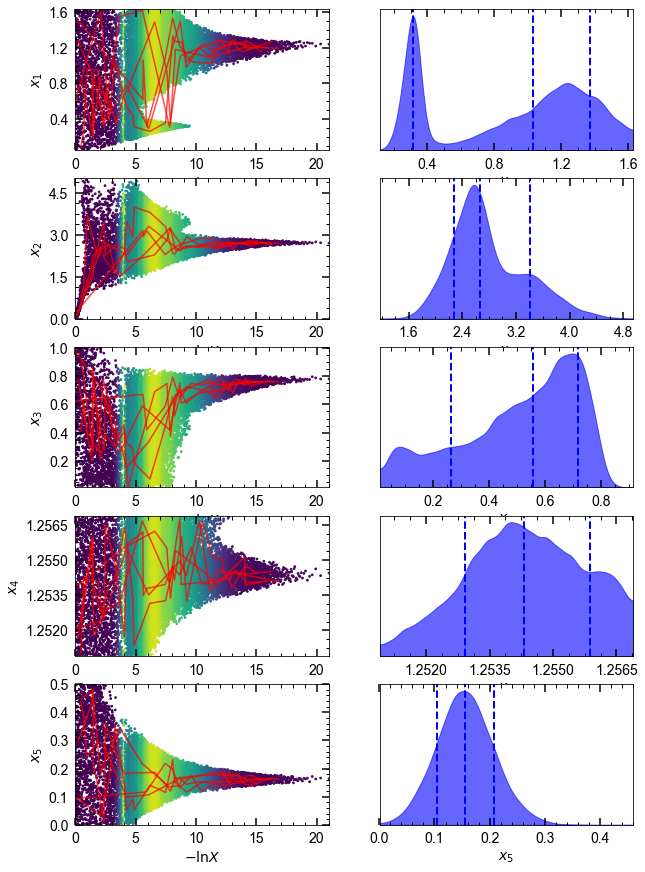

In [50]:
fig, axes = dyplot.traceplot(dresG, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 10, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(5, 2, figsize=(10, 15)))

(<Figure size 849.6x849.6 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a7ef44128>,
       dtype=object))

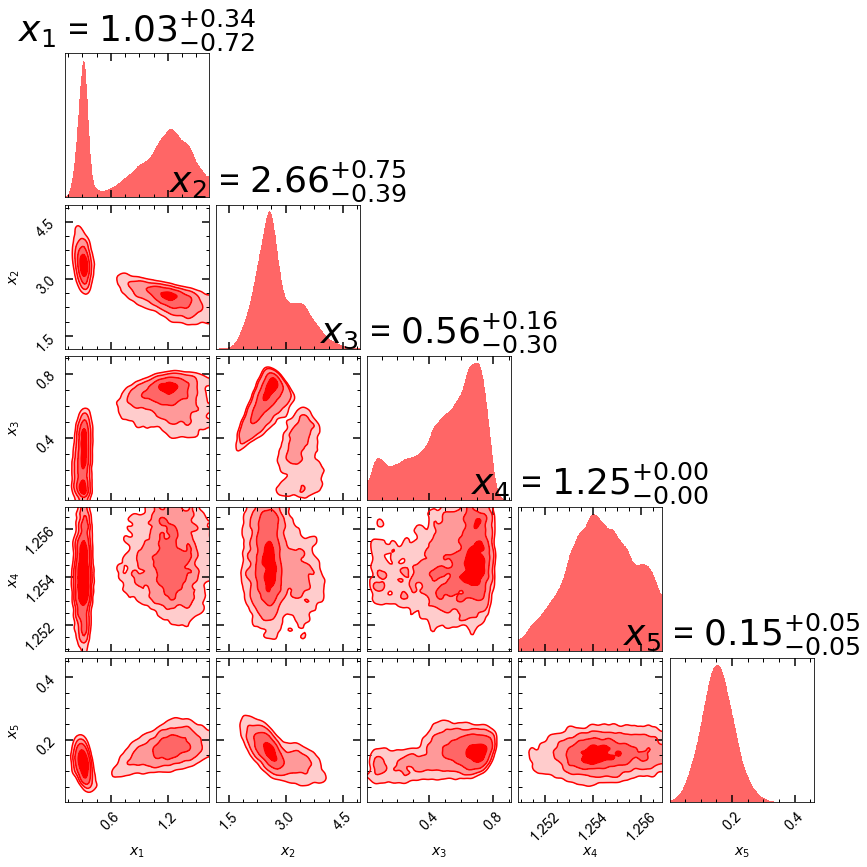

In [51]:
# initialize figure
# fig, axes = plt.subplots(5, 5, figsize=(35, 20))
# axes = axes.reshape((5, 5))

# plot extended run (right)
# fg, ax = 
dyplot.cornerplot(dresG, color='red', truths=None, truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, )#fig=(fig, axes))

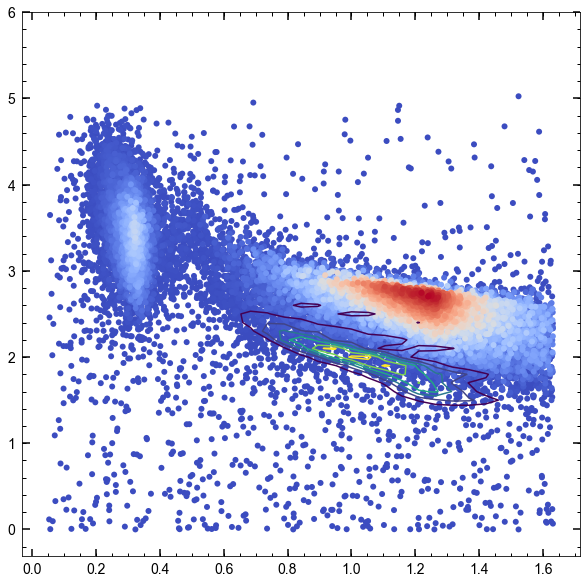

In [53]:
P = np.load('../../Quiescent_analysis/chidat/n21156_dtau_rf_tZ_pos.npy')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)

M,A=np.meshgrid(metal/0.019,age)


fig = plt.figure(figsize=(10, 10))

plt.scatter(dresG.samples[:, 0], dresG.samples[:, 1],
               marker='o', c=np.exp(dresG.logl), linewidths=(0.,), cmap='coolwarm')
plt.contour(M,A,P)


In [317]:
dres_test.keys()

dict_keys(['logzerr', 'samples', 'eff', 'samples_it', 'bound', 'ncall', 'information', 'batch_bounds', 'samples_n', 'logwt', 'niter', 'scale', 'logl', 'logz', 'samples_batch', 'bound_iter', 'samples_u', 'logvol', 'samples_id', 'batch_nlive', 'samples_bound'])

In [319]:
np.save('../data/out_dict/dres_test.npy', dres_test) 

In [ ]:
O